In [1]:
import astropy.io.fits as pyfits
import numpy as np
import sep
import matplotlib.pyplot as plt
import astropy.table as atpy
from skimage.feature import canny
from skimage.transform import rotate
from matplotlib.backends.backend_pdf import PdfPages
import time

In [2]:
def norm(x):
    med = np.median(x)
    std = np.median(np.abs(x - med))
    return (x - med) / std

In [3]:
def find_angle(ima, ref):
    # find the best orientation
    imas = []
    ang_step = 1
    angles = np.arange(0, 360, ang_step)
    for i in angles:
        imas.append(rotate(ima * 1., i))
    imas = np.array(imas)
    imas = imas / (np.sum(imas**2, axis=1).sum(axis=1)**.5)[:, None, None]
    ref = ref / np.sum(ref**2)**.5
    pos = (ref[None, :, :] * imas).sum(axis=1).sum(axis=1)
    return angles[np.argmax(pos)]

In [4]:
def perc(X, per):
    return scipy.stats.scoreatpercentile(X, per)

In [5]:
def doit(fname_front, fname_back, ref_fname='temp2.fits', doplot=False):
    # process the front/back iluminated images
    D = pyfits.getdata(fname_front)
    dat = pyfits.getdata(fname_back)
    dat = dat - np.median(dat)
    thresh = 120  # threshold for detecting fibers
    det = sep.extract(dat, thresh)
    cans = []
    peakv = 10000  # minimum value of the peak
    pad = 40  # padding around the fiber

    ref = pyfits.getdata(ref_fname)
    det = atpy.Table(det)
    det['angle'] = np.nan
    for curi in range(len(det['x'])):
        if det['peak'][curi] < peakv:
            continue
        curx, cury = int(det['y'][curi]), int(det['x'][curi])
        curD = D[curx - pad:curx + pad, cury - pad:cury + pad]
        curd = dat[curx - pad:curx + pad, cury - pad:cury + pad]
        curD = norm(curD)
        can = canny(curD, sigma=2)
        # cans.append(rotate(can*1.,find_angle(can,ref)))
        angle = np.deg2rad(find_angle(can, ref) - 90)
        det['angle'][curi] = angle

        if doplot:
            plt.clf()
            plt.subplot(131)
            Rs = np.r_[0, 30]
            plt.imshow(curD, vmax=perc(curD, .95))
            plt.plot(pad + np.cos(angle) * Rs,
                     pad + np.sin(angle) * Rs,
                     color='red')
            plt.subplot(132)
            plt.imshow(curd, vmax=perc(curd, .99))
            plt.subplot(133)
            plt.imshow(can)
    # plt.pause(.1)
    # pdf.savefig()
    # pdf.close()
    return det

Text(0.5, 1.0, 'Reference image')

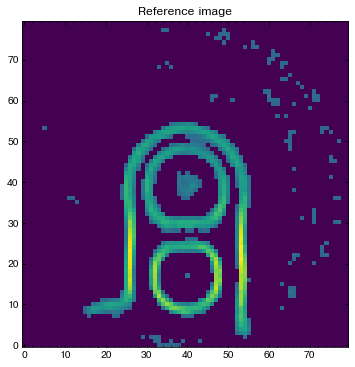

In [6]:
fronti = 'fvc.20200625122049.fits'
backi = 'fvc.20200625120853.fits'
ref_fname = 'temp2.fits'
ref = pyfits.getdata(ref_fname)
plt.figure(figsize=(6, 6))
plt.imshow(ref)
plt.title('Reference image')

In [8]:
t1 = time.time()
dets = doit(fronti, backi, ref_fname=ref_fname)  # run the detection
print('Time ', time.time() - t1)
dets.write('detections.fits', overwrite=True)

Time  97.01761531829834


(4000.0, 5000.0)

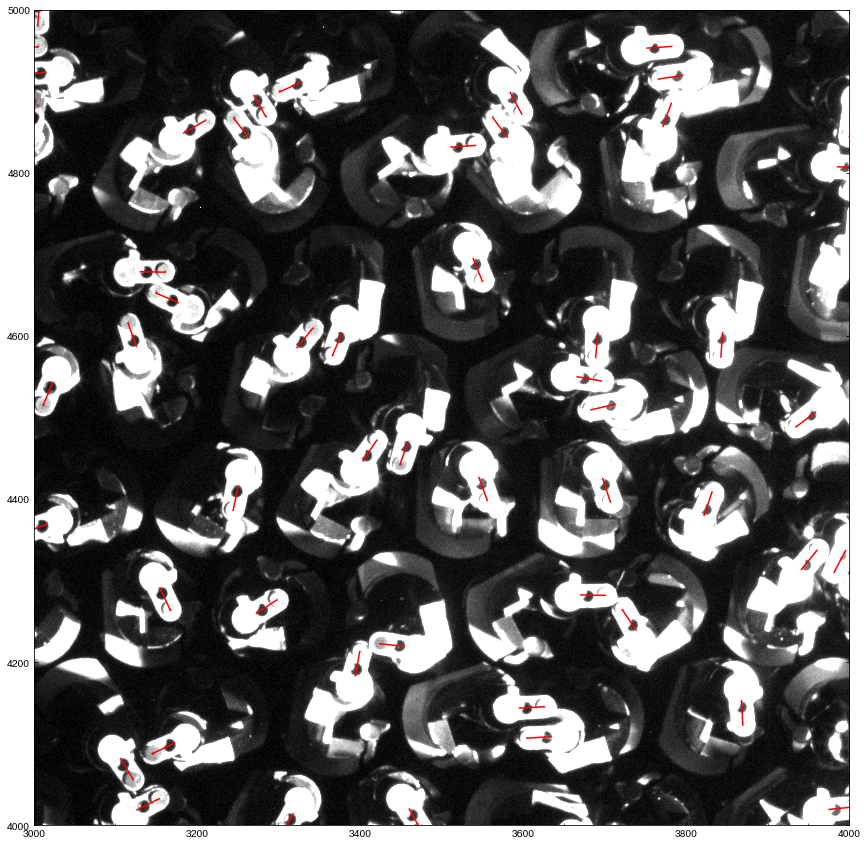

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(pyfits.getdata(fronti),cmap='gray',vmax=3000,vmin=2000)
for x,y,ang in zip(dets['x'],dets['y'],dets['angle']):
    plt.plot(x+np.r_[0,30]*np.cos(ang),y+np.r_[0,30]*np.sin(ang),color='red')
plt.xlim(3000, 4000)
plt.ylim(4000, 5000)